In [212]:
import numpy as np
import csv
from scipy.interpolate import CubicSpline, PPoly
import matplotlib.pyplot as plt
debug = True
def dbp(*args):
    # Debug mode printouts
    if debug:
        print(" ".join([str(a) for a in args]))

In [213]:
class Fluid:
    def __init__(self, h_file, cp_file, s_file=None, r_file=None):
        self.Pc = None
        self.Tc = None
        self.s0 = None
        self.T0 = 400
        self.P0 = 1
        self.gamma = None
        self.R = 1
        
        with open(cp_file, mode='r', newline='') as f:
            reader = csv.reader(f)
            cp_data = np.array([[s.replace(',', '') for s in r] for r in reader])
        cptab = Table(P=cp_data[0,1:].astype(float), T=cp_data[1:,0].astype(float), data=cp_data[1:,1:].astype(float))
        self.tables = dict()
        self.tables['h'] = self.read_table(h_file)
        self.tables['cp'] = self.read_table(cp_file)
        self.tables['r'] = self.read_table(r_file)
        self.tables['s'] = self.read_table(s_file)
    
    # reads in csv file
    def read_table(self, fname):
        with open(fname, mode='r', newline='') as f:
            reader = csv.reader(f)
            data = np.array([[s.replace(',', '') for s in r] for r in reader])
        table = Table(P=data[0,1:].astype(float), T=data[1:,0].astype(float), data=data[1:,1:].astype(float))
        return table
    
    # Setting up API to return a full state with all properties based upon only two values
    def state(self, **kwargs):
    # e.g.:
        # pump_exit = H2.state(P=5, T=800); print(pump_exit.h)
        # plt.plot(range(1, 5), [H2.state(pressure=Pi, s=1800).v for Pi in range(1, 5)])
        if len(kwargs)==2:
            kw1 = list(kwargs.keys())[0]
            kw2 = list(kwargs.keys())[1]
        else:
            raise ValueError("Two properties are required to determine the fluid state")
        check = {'p':('P', 'PRESSURE', 'PRESS'),
                 't':('T', 'TEMPERATURE', 'TEMP'),
                 's':('S', 'ENTROPY'), 
                 'h':('H', 'ENTHALPY'),
                 'v':('V', 'VOLUME', 'SPECIFIC_VOLUME', 'VOL'), 
                 'r':('R', 'RHO', 'DENSITY')}
        input_props = dict()
        for key, vals in check.items():
            if kw1.upper() in vals:
                input_props[key] = int(kwargs[kw1])
            elif kw2.upper() in vals:
                input_props[key] = int(kwargs[kw2])
        dbp("Input state properties:", input_props)
        if len(input_props)!=2:
            raise ValueError("Input properties not recognized")
        return FluidState(self, input_props)

In [214]:
class Process:
    def __init__(self, state1, state2):
        pass

In [215]:
class FluidState:
    def __init__(self, fluid, props):
        self.P = None
        self.T = None
        self.h = None
        self.v = None
        self.r = None
        self.s = None
        self.cp = None
        self.fluid = fluid
        self.solve_properties(props)

    # solve for all properties of the fluid
    def solve_properties(self, props):
        pt_count = 0
        keys = list(props.keys())
        if 'v' in keys: # convert specific volume to density
            props['r'] = 1 / props['v']
            keys.remove('v')
            keys.append('r')
        
        if 't' in keys:
            self.T = props['t']
            pt_count += 1
        if 'p' in keys:
            self.P = props['p']
            pt_count += 1
        
        # Solve for both pressure and temperature if needed
        if pt_count == 0:
            self.P, self.T = self.double_solve(props[keys[0]], self.fluid.tables[keys[0]], props[keys[1]], self.fluid.tables[keys[1]])
        
        # Solve for only one of either pressure or temperature if needed
        if pt_count == 1:
            if self.T is None:
                other_key = keys[keys!='p'][0]
                self.T = self.fluid.tables[other_key].get_t( P1=self.P, Y1=props[other_key])
                
            elif self.P is None:
                other_key = keys[keys!='t'][0]
                self.P = self.fluid.tables[other_key].get_t( P1=self.P, Y1=props[other_key])
        dbp("Pressure:", self.P, "--- Temperature:", self.T)
        
        # Set specific heat property
        self.cp = self.fluid.tables['cp'].interp(P1=self.P, T1=self.T)
        
        # Set density property
        if 'r' in keys:
            self.r = props['r']
        else:
            self.r = self.fluid.tables['r'].interp(P1=self.P, T1=self.T)
        self.v = 1 / self.r
        
        # Set enthalpy property
        if 'h' in keys:
            self.h = props['h']
        else:
            self.h = self.fluid.tables['h'].interp(P1=self.P, T1=self.T)
        
        # set entropy property
        if 's' in keys:
            self.s = props['s']
        else:
            self.s = self.fluid.tables['s'].interp(P1=self.P, T1=self.T)
    
    
    # solve for both pressure and temperature as a function of other variables
    def double_solve(self, value1, table1, value2, table2):
        t1_p = table1.t_func_p(value1) #T(P) given property 1
        t2_p = table2.t_func_p(value2) #T(P) given property 2
        
        pmax = min(max(t1_p.x), max(t2_p.x))
        pmin = max(min(t1_p.x), min(t2_p.x))
        x_new = []
        c_new = []
        
        # iterate over pressure values for each
        dbp("X1:", t1_p.x.shape)
        dbp("C1:", t1_p.c.shape)
        for i in range(len(t1_p.x)):
            for j in range(len(t2_p.x)):
                p1 = t1_p.x[i]
                p2 = t2_p.x[j]
                if (max(p1,p2)>pmax) or (min(p1,p2)<pmin):
                    continue
                else:
                    # Append final x-value
                    if (i==len(t1_p.x)-1) and (j==len(t2_p.x)-1):
                        dbp("Last loop reached for intersection")
                        x_new.append(min(p1, p2))
                    elif p1==p2:
                        c1 = t1_p.c[:,i]
                        c2 = t2_p.c[:,j]
                        x_new.append(p1)
                        c_new.append(c1 - c2)
    
        c=np.array(c_new).transpose(); x=np.array(x_new)
        dbp(c.shape)
        dbp(x.shape)
        difference = PPoly(c=c, x=x, extrapolate=False)
        pressure_values = table1.combine(difference.solve(0))
        if len(pressure_values)!=1:
            print(pressure_values)
            raise ValueError("No Unique Solution Found")
        else:
            temperature = t1_p(pressure_values[0])
            return pressure_values[0], temperature
                
    # control printout behavior of fluid state
    def __str__(self):
        pstr = [f"Fluid state with properties:",
                f"[P] Pressure: {self.P}",
                f"[T] Temperature: {self.T}",
                f"[h] Enthalpy: {self.h}",
                f"[r] Density: {self.r}",
                f"[v] Specific Volume: {self.v}",
                f"[s] Entropy: {self.s}"]
        return "\n\t".join(pstr)

In [216]:
# property table which contains some data indexed to pressure (columns) and temperature (rows)
class Table:
    def __init__(self, P, T, data):
        self.P = P
        self.T = T
        self.data = data
        self.tol = 1e-5 # tolerance for removing duplicate values
        
        # create spline fits as a function of pressure at specified temperatures
        self.cs_p = [] 
        for i in range(len(self.T)):
            self.cs_p.append(CubicSpline(self.P, self.data[i,:], extrapolate=False))
            
        # create spline fits as a function of temperature at specified pressures    
        self.cs_t = []                   
        for j in range(len(self.P)): 
            self.cs_t.append(CubicSpline(self.T, self.data[:,j], extrapolate=False))
    
    # get property value from pressure and temperature
    def interp(self, P1, T1):
        FP = self.func_p(T1)
        FT = self.func_t(P1)
        return (FP(P1) + FT(T1)) / 2
    
    # Property as a function of temperature at specified pressure P1
    def func_t(self, P1):
        at_p1 = []
        for i in range(len(self.T)):
            at_p1.append(self.cs_p[i](P1))
        return CubicSpline(self.T, at_p1, extrapolate=False)
    
    # Property as a function of pressure at specified temperature T1
    def func_p(self, T1):
        at_t1 = []
        for j in range(len(self.P)):
            at_t1.append(self.cs_t[j](T1))
        return CubicSpline(self.P, at_t1, extrapolate=False)
    
    # get pressure value from given temperature and property value (not recommended for enthalpy tables)
    def get_p(self, T1, Y1):
        func = self.func_p(T1)
        solns = self.combine(func.solve(Y1))
        if len(solns)!=1:
            print(solns)
            raise ValueError("No Unique Solution Found")
        return solns[0]
    
    # get temperature as a function of pressure for given property value
    def t_func_p(self,Y1):
        # find temperature at tabulated pressures and given property value Y1
        intercepts = dict()
        dbp(Y1)
        dbp(self.T)
        for i in range(len(self.P)):
            T = self.combine(self.cs_t[i].solve(Y1))
            dbp(T)
            # Check that there is only one valid temperature solution at each pressure
            if len(T)==0:
                pass
            elif len(T)==1:
                intercepts[self.P[i]] = T[0]
            else:
                raise ValueError("No Unique Solution Found")
        
        # return function T(P) created from interpolation of these points
        dbp(list(intercepts.keys()), list(intercepts.values()))
        return CubicSpline(list(intercepts.keys()), list(intercepts.values()), extrapolate=False)
    
    # get temperature from pressure and property value
    def get_t(self, P1, Y1):
        func = self.func_t(P1)
        solns = self.combine(func.solve(Y1))
        if len(solns)!=1:
            print(solns)
            raise ValueError("No Unique Solution Found")
        return solns[0]
    
    # remove duplicate and NaN solutions
    def combine(self, vals):
        unique = []
        for i in range(len(vals)):
            for j in range(i,len(vals)):
                if i!=j and (abs(vals[i] - vals[j]) < self.tol):
                    break
                if np.isnan(vals[i]):
                    break
            else:
                unique.append(vals[i])
        return unique

Input state properties: {'h': -100, 'r': 1}
-100
[  400.   500.   600.   700.   800.   900.  1000.  1100.  1200.  1300.
  1400.  1500.  1600.  1700.  1800.  1900.  2000.  2100.  2200.  2300.
  2400.  2500.  2600.  2700.  2800.  2900.  3000.  3100.  3200.  3400.
  3600.  3800.  4000.  4200.  4400.  4600.  4800.  5000.  5200.  5400.
  5600.  5800.  6000.  6300.  6600.  7000.  7300.  7600.  8000.  8300.
  8600.  9000.  9300.  9600. 10000.]
[2763.2505645879255]
[2911.9777382825673]
[3093.038147482486]
[3277.7424020778153]
[3503.93923423576]
[3736.7394903090503]
[4025.365252592932]
[4325.138607297019]
[4701.356711273467]
[5094.118238100766]
[5589.080319653579]
[6106.014817443672]
[0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 10.0, 30.0, 100.0, 300.0] [2763.2505645879255, 2911.9777382825673, 3093.038147482486, 3277.7424020778153, 3503.93923423576, 3736.7394903090503, 4025.365252592932, 4325.138607297019, 4701.356711273467, 5094.118238100766, 5589.080319653579, 6106.014817443672]
1
[  400.  

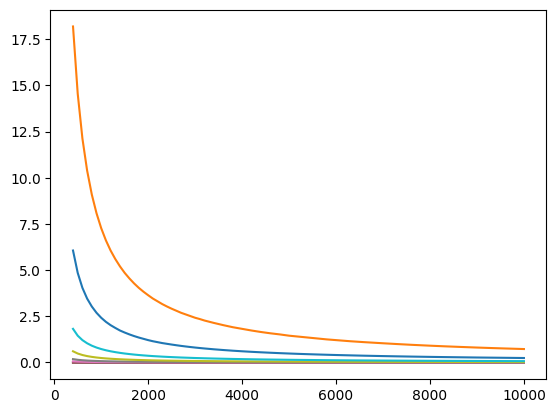

In [217]:
H2 = Fluid("H2_data_h.csv", "H2_data_Cp.csv", "H2_data_h.csv", "H2_data_rho_placeholder.csv")
#print(H2.tables['r'].data)

for j in range(len(H2.tables['r'].P)):
    plt.plot(H2.tables['r'].T, H2.tables['r'].data[:,j])

a = H2.state(h=-100, rho=1.5)
print(a)